# Lab Assignment Four: Multi-Layer Perceptron

## 1.Load, Split, and Balance

- [.5 points] Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the variables until asked to do so.  Remove any observations that having missing data. Encode any string data as integers for now. 
- [.5 points] Assume you are equally interested in the classification performance for each class in the dataset. Split the dataset into 80% for training and 20% for testing.
- [.5 points] Balance the dataset so that about the same number of instances are within each class. Choose a method for balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization thresholds for the "ChildPoverty" variable that equally divide the data into four classes. Should balancing of the dataset be done for both the training and testing set? Explain.

In [1]:
#import the lib needed 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy.special import expit
from sklearn.model_selection import train_test_split
import copy
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import sys
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn import metrics as mt
from sklearn.model_selection import GridSearchCV

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('ggplot')

print("numpy version is:",np.__version__)
print("pandas version is:",pd.__version__)

numpy version is: 1.20.2
pandas version is: 1.2.3


In [2]:
df = pd.read_csv('./data/acs2017_census_tract_data.csv')

pd.set_option('display.max_columns', None)
df.describe(include='all')

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,7.400100e+04,74001,74001,74001.000000,74001.000000,74001.000000,73305.000000,73305.000000,73305.00000,73305.000000,73305.000000,73305.000000,74001.000000,72885.000000,72885.000000,73256.000000,73256.000000,73159.000000,72891.000000,73190.000000,73190.000000,73190.000000,73190.000000,73190.000000,73200.000000,73200.000000,73200.000000,73200.000000,73200.000000,73200.000000,73055.000000,74001.000000,73190.000000,73190.000000,73190.000000,73190.000000,73191.000000
unique,NaN,52,1955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,California,Los Angeles County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,8057,2346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.839113e+10,NaN,NaN,4384.716017,2157.710707,2227.005311,17.265444,61.309043,13.28910,0.734047,4.753691,0.147341,3102.885961,61086.829265,9697.465747,30651.804194,4270.174225,16.118186,21.155872,35.559478,18.874446,23.427724,9.239350,12.899281,75.698005,9.308369,5.395186,3.042825,1.894605,4.661466,26.056594,2049.152052,79.494222,14.163342,6.171484,0.171164,7.246738
std,1.647593e+10,NaN,NaN,2228.936729,1120.560504,1146.240218,23.073811,30.634461,21.60118,4.554247,8.999888,1.029250,1542.245024,30516.098180,6154.669518,16126.937143,3148.049041,12.691045,18.645759,15.144984,8.137261,5.806091,6.031393,7.712496,15.292660,5.222494,11.689470,5.805753,2.549374,4.014940,7.124524,1138.865457,8.126383,7.328680,3.932364,0.456580,5.227624
min,1.001020e+09,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2692.000000,728.000000,32.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.303901e+10,NaN,NaN,2903.000000,1416.000000,1465.000000,2.600000,38.000000,0.80000,0.000000,0.200000,0.000000,2061.000000,40357.000000,5735.000000,20556.750000,2503.000000,6.900000,6.200000,24.700000,13.300000,19.700000,5.000000,7.100000,72.200000,5.700000,0.000000,0.400000,0.400000,2.000000,21.100000,1276.000000,75.200000,9.300000,3.500000,0.000000,3.900000
50%,2.804700e+10,NaN,NaN,4105.000000,2007.000000,2082.000000,7.400000,70.400000,3.80000,0.000000,1.500000,0.000000,2905.000000,54375.000000,8267.000000,27215.500000,3404.000000,12.600000,16.300000,33.300000,17.700000,23.200000,8.300000,11.800000,79.900000,8.500000,1.000000,1.400000,1.200000,3.800000,25.400000,1895.000000,80.600000,13.000000,5.500000,0.000000,6.000000
75%,4.200341e+10,NaN,NaN,5506.000000,2707.000000,2803.000000,21.100000,87.700000,14.60000,0.400000,5.000000,0.000000,3906.000000,74659.000000,11913.000000,36408.250000,4968.250000,21.800000,31.600000,44.900000,23.300000,26.900000,12.500000,17.500000,84.900000,11.900000,4.600000,3.300000,2.500000,6.300000,30.300000,2635.000000,85.000000,17.600000,8.000000,0.000000,9.000000


In [3]:
df.dtypes

TractId               int64
State                object
County               object
TotalPop              int64
Men                   int64
Women                 int64
Hispanic            float64
White               float64
Black               float64
Native              float64
Asian               float64
Pacific             float64
VotingAgeCitizen      int64
Income              float64
IncomeErr           float64
IncomePerCap        float64
IncomePerCapErr     float64
Poverty             float64
ChildPoverty        float64
Professional        float64
Service             float64
Office              float64
Construction        float64
Production          float64
Drive               float64
Carpool             float64
Transit             float64
Walk                float64
OtherTransp         float64
WorkAtHome          float64
MeanCommute         float64
Employed              int64
PrivateWork         float64
PublicWork          float64
SelfEmployed        float64
FamilyWork          

### There are two columns of data required to transform into integers. I use LabelEncoder to encode the string data of State and County to integers and add them into the dataframe in the column "State_C" and "County_C" respectively.

In [4]:
df['State_C'] = LabelEncoder().fit_transform(df['State'])
df['County_C'] = LabelEncoder().fit_transform(df['County'])

df.head()

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,State_C,County_C
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,1.2,0.0,1407,67826.0,14560.0,33018.0,6294.0,10.7,20.8,38.5,15.6,22.8,10.8,12.4,94.2,3.3,0.0,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6,0,89
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,1.0,0.0,1652,41287.0,3819.0,18996.0,2453.0,22.4,35.8,30.5,24.9,22.9,6.3,15.4,90.5,9.1,0.0,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4,0,89
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,0.7,0.4,2480,46806.0,9496.0,21236.0,2562.0,14.7,21.1,27.9,19.4,33.3,9.9,9.6,88.3,8.4,0.0,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7,0,89
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,0.2,0.0,3257,55895.0,4369.0,28068.0,3190.0,2.3,1.7,29.0,16.6,25.8,9.1,19.5,82.3,11.2,0.0,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1,0,89
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,3.1,0.0,7229,68143.0,14424.0,36905.0,10706.0,12.2,17.9,48.8,13.8,20.5,3.5,13.4,86.9,11.2,0.0,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3,0,89


### To check if there are NA in this dataset

In [5]:
print(df.isna().sum())

TractId                0
State                  0
County                 0
TotalPop               0
Men                    0
Women                  0
Hispanic             696
White                696
Black                696
Native               696
Asian                696
Pacific              696
VotingAgeCitizen       0
Income              1116
IncomeErr           1116
IncomePerCap         745
IncomePerCapErr      745
Poverty              842
ChildPoverty        1110
Professional         811
Service              811
Office               811
Construction         811
Production           811
Drive                801
Carpool              801
Transit              801
Walk                 801
OtherTransp          801
WorkAtHome           801
MeanCommute          946
Employed               0
PrivateWork          811
PublicWork           811
SelfEmployed         811
FamilyWork           811
Unemployment         810
State_C                0
County_C               0
dtype: int64


In [6]:
# drop the rows contained NA data. 
df = df.dropna()
print(df.isna().sum())

TractId             0
State               0
County              0
TotalPop            0
Men                 0
Women               0
Hispanic            0
White               0
Black               0
Native              0
Asian               0
Pacific             0
VotingAgeCitizen    0
Income              0
IncomeErr           0
IncomePerCap        0
IncomePerCapErr     0
Poverty             0
ChildPoverty        0
Professional        0
Service             0
Office              0
Construction        0
Production          0
Drive               0
Carpool             0
Transit             0
Walk                0
OtherTransp         0
WorkAtHome          0
MeanCommute         0
Employed            0
PrivateWork         0
PublicWork          0
SelfEmployed        0
FamilyWork          0
Unemployment        0
State_C             0
County_C            0
dtype: int64


### I divide the column "ChildPoverty" into 4 balanced classes by quantile and set it up as column "ChildPoverty_C" in the dataframe.

In [7]:
df['ChildPoverty_C'] = pd.qcut(df.ChildPoverty,4,labels=(0,1,2,3))
print(np.bincount(df['ChildPoverty_C']))
print(np.unique(df['ChildPoverty_C']))

[18229 18171 18148 18170]
[0 1 2 3]


### I drop the columns of TractId because it is unrelated to the classification task or even adding noise to the outcome.

In [8]:
df1 = df.drop(['State','County','ChildPoverty','TractId'],axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72718 entries, 0 to 74000
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   TotalPop          72718 non-null  int64   
 1   Men               72718 non-null  int64   
 2   Women             72718 non-null  int64   
 3   Hispanic          72718 non-null  float64 
 4   White             72718 non-null  float64 
 5   Black             72718 non-null  float64 
 6   Native            72718 non-null  float64 
 7   Asian             72718 non-null  float64 
 8   Pacific           72718 non-null  float64 
 9   VotingAgeCitizen  72718 non-null  int64   
 10  Income            72718 non-null  float64 
 11  IncomeErr         72718 non-null  float64 
 12  IncomePerCap      72718 non-null  float64 
 13  IncomePerCapErr   72718 non-null  float64 
 14  Poverty           72718 non-null  float64 
 15  Professional      72718 non-null  float64 
 16  Service           7271

In [9]:
y = np.array(df1['ChildPoverty_C'])
df1.drop(['ChildPoverty_C'],axis=1,inplace=True)


#### I have done the one hot encoding of two categorical data, State and County, because I found it complicated to cope with the one hot encoding when I have separated the training set and testing set since the training and testing set may have not all the values of categorical data. However, I don't use them until being asked.

In [10]:
one_hot_state = LabelBinarizer().fit_transform(df1['State_C'])
print(one_hot_state.shape)
one_hot_county = LabelBinarizer().fit_transform(df1['County_C'])
print(one_hot_county.shape)


(72718, 52)
(72718, 1954)


In [11]:
X_not_hot_encoding_or_normalization = np.array(df1)
X_not_normalization = np.hstack((X_not_hot_encoding_or_normalization[:,0:33],one_hot_state,one_hot_county))

In [12]:
print('X.shape:',X_not_hot_encoding_or_normalization.shape)
print('y.shape:',X_not_hot_encoding_or_normalization.shape)

print('X_not_hot_encoding_or_normalization',X_not_hot_encoding_or_normalization.shape)
print('X_not_normalization',X_not_normalization.shape)



X.shape: (72718, 35)
y.shape: (72718, 35)
X_not_hot_encoding_or_normalization (72718, 35)
X_not_normalization (72718, 2039)


(array([18229.,     0.,     0., 18171.,     0.,     0., 18148.,     0.,
            0., 18170.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

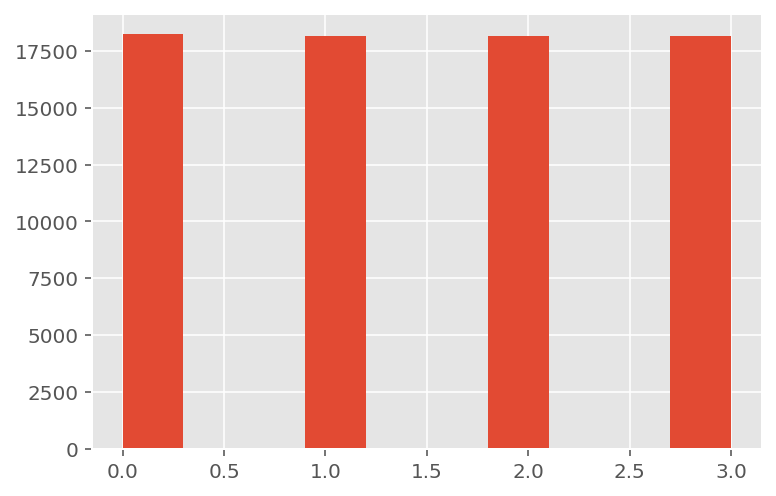

In [13]:
plt.hist(y)

## Split the dataset into 80% for training and 20% for testing.

In [14]:
X_not_hot_encoding_or_normalization_train, X_not_hot_encoding_or_normalization_test, y_train, y_test = train_test_split(X_not_hot_encoding_or_normalization,y,test_size=0.2, train_size=0.8)
X_not_normalization_train, X_not_normalization_test, y_train, y_test = train_test_split(X_not_normalization,y,test_size=0.2, train_size=0.8)

In [15]:
print("X_not_hot_encoding_or_normalization_train",X_not_hot_encoding_or_normalization_train.shape)
print("X_not_hot_encoding_or_normalization_test",X_not_hot_encoding_or_normalization_test.shape)
print("X_not_normalization_train",X_not_normalization_train.shape)
print("X_not_normalization_test",X_not_normalization_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

X_not_hot_encoding_or_normalization_train (58174, 35)
X_not_hot_encoding_or_normalization_test (14544, 35)
X_not_normalization_train (58174, 2039)
X_not_normalization_test (14544, 2039)
y_train (58174,)
y_test (14544,)


## Should balancing of the dataset be done for both the training and testing set?

It's not necessary to do balancing on the testing dataset because testing set is used for evaluating learning capability of the model. It's critical to have a balanced dataset for training set so that the model could maximize its possibility to learn plenty of details from the training data.

## 2.Pre-processing

There are a number of version of the two layer perceptron covered in class. When using the example two layer network from class be sure that you use: (1) vectorized computation, (2) mini-batching, and (3) proper Glorot initialization, at a minimum.  

- [.5 points] Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs. 
- [.5 points] Now normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.  
- [.5 points] Now normalize the continuous numeric feature data AND one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs. 
- [1 points] Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.  
    - Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.

In [16]:
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 l2_C=0.0, epochs=500, eta=0.001, random_state=None, onehot=True, alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = l2_C
        self.epochs = epochs
        self.eta = eta
        self.onehot = onehot
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    def _encode_labels(self,y):
        """Encode labels into one-hot representation"""
        if self.onehot:
            return pd.get_dummies(y).values.T
        else:
            return y[np.newaxis]
            
            
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        # print('W1.shape ',W1.shape)
        # print('W2.shape ',W2.shape)

        return W1, W2

    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

    def graph_loss_function(self):
        cost_avgs = [np.mean(x) for x in self.cost_]
        plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
        plt.ylabel('Cost')
        plt.xlabel('Epochs')
        plt.tight_layout()
        plt.show()

    # In order to be available as scikit-learn estimator, I develop the two functions. 
    def get_params(self, deep=True):
        return {"n_hidden": self.n_hidden, 
                "l2_C": self.l2_C,
                "epochs": self.epochs,
                "eta": self.eta,
                "onehot": self.onehot,
                "alpha": self.alpha,
                "decrease_const": self.decrease_const,
                "shuffle": self.shuffle,
                "minibatches": self.minibatches
                }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [17]:
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)

        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        # print('V1.shape ',V1.shape)
        # print('V2.shape ',V2.shape)

        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        if self.onehot == False:
            y_pred = A3.T.reshape(A3.shape[1]).astype(int)
        else:
            y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()
        
        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            eta = self.eta / (1 + self.decrease_const*i) # decreasing learning rate
            # there are many forms of adaptive learning rates out there!

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches== self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1, W2=self.W2)
                
                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)

        return self


### 2.1 Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs.

In [18]:
params = dict(n_hidden=50, 
              l2_C=0.0, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=1e-2,  # learning rate
              random_state=1,
              onehot=True,
              alpha=0.9,
              decrease_const=0.1,
              minibatches=len(X_not_hot_encoding_or_normalization_train)/64,
              shuffle=True
              )

Epoch: 100/100
Accuracy: 0.25192519251925194
[0 1 2 3]


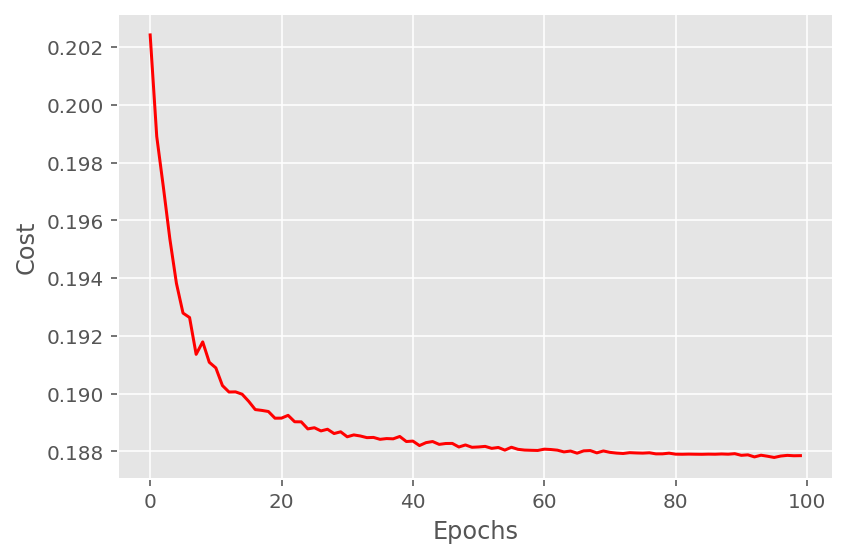

CPU times: user 13.1 s, sys: 278 ms, total: 13.4 s
Wall time: 14.2 s


In [19]:
%%time
# nn1 is 2 layers neural network implementation without normalization or one-hot encode
nn1 = TwoLayerPerceptron(**params)
nn1.fit(X_not_hot_encoding_or_normalization_train, y_train, print_progress=1)
yhat_nn1 = nn1.predict(X_not_hot_encoding_or_normalization_test)
print()
# print(np.unique(yhat_nn1))
print('Accuracy:',accuracy_score(y_test,yhat_nn1))
print(np.unique(yhat_nn1))
nn1.graph_loss_function()

### 2.2 Now normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.

In [20]:
sds = StandardScaler()
X_not_hot_encoding_or_normalization_train[:,0:33] = sds.fit_transform(X_not_hot_encoding_or_normalization_train[:,0:33])
X_not_hot_encoding_or_normalization_test[:,0:33] = sds.transform(X_not_hot_encoding_or_normalization_test[:,0:33])
X_not_hot_encoding_train = X_not_hot_encoding_or_normalization_train
X_not_hot_encoding_test = X_not_hot_encoding_or_normalization_test
X_not_normalization_train[:,0:33] = sds.fit_transform(X_not_normalization_train[:,0:33])
X_not_normalization_test[:,0:33] = sds.transform(X_not_normalization_test[:,0:33])
X_train = X_not_normalization_train
X_test = X_not_normalization_test

Epoch: 100/100
Accuracy: 0.25254400440044006
[0 2 3]


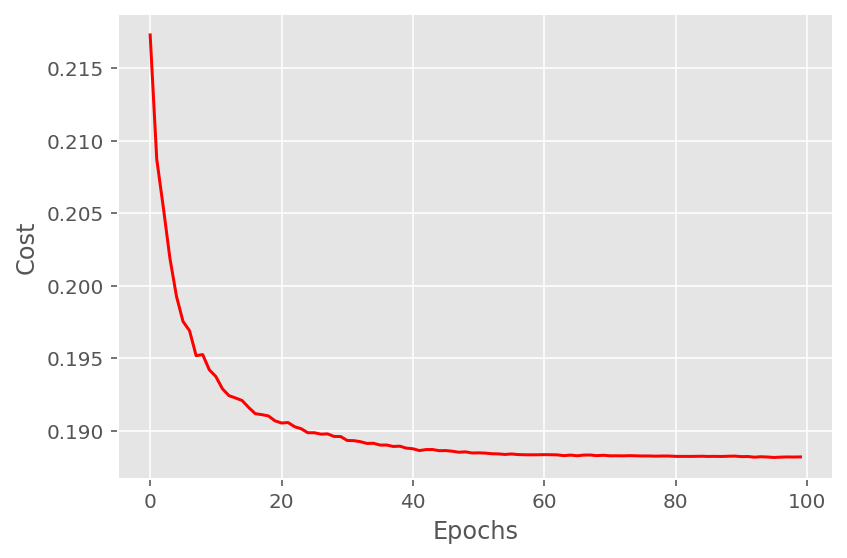

CPU times: user 13.6 s, sys: 228 ms, total: 13.8 s
Wall time: 14.9 s


In [21]:
%%time
# nn2 is 2 layers neural network implementation with normalization but without one-hot encode
params['epochs'] = 100
params['l2_C']=1e-2
nn2 = TwoLayerPerceptron(**params)
nn2.fit(X_not_hot_encoding_train, y_train, print_progress=1)
yhat_nn2 = nn2.predict(X_not_hot_encoding_test)
print()
print('Accuracy:',accuracy_score(y_test,yhat_nn2))
print(np.unique(yhat_nn2))
nn2.graph_loss_function()

### 2.3 Now normalize the continuous numeric feature data AND one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.

Epoch: 100/100
Accuracy: 0.7367299229922992
[0 1 2 3]


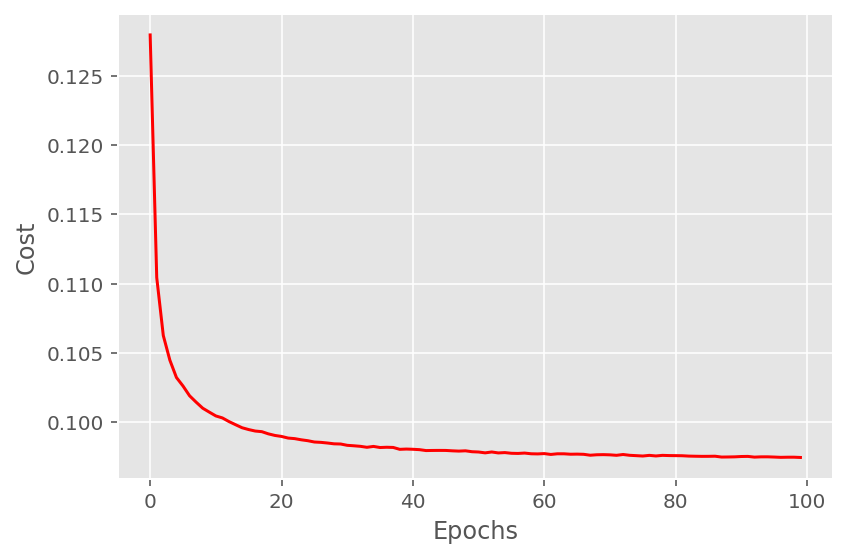

CPU times: user 10h 41min 44s, sys: 7min 19s, total: 10h 49min 4s
Wall time: 2h 43min 19s


In [22]:
%%time
# nn3 is 2 layers neural network implementation with normalization and one-hot encode
params['epochs'] = 100
nn3 = TwoLayerPerceptron(**params)
nn3.fit(X_train, y_train, print_progress=1)
yhat_nn3 = nn3.predict(X_test)
print()
print('Accuracy:',accuracy_score(y_test,yhat_nn3))
print(np.unique(yhat_nn3))
nn3.graph_loss_function()

### 2.4 Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.(Need to use statistical method)

In [23]:
%%time

accuracy_nn1 = accuracy_score(y_test,yhat_nn1)
accuracy_nn2 = accuracy_score(y_test,yhat_nn2)
accuracy_nn3 = accuracy_score(y_test,yhat_nn3)


d1 = np.abs(accuracy_nn1-accuracy_nn2)
d2 = np.abs(accuracy_nn2-accuracy_nn3)
d3 = np.abs(accuracy_nn1-accuracy_nn3)

v1 = accuracy_nn1*(1-accuracy_nn1)/X_test.shape[0] + accuracy_nn2*(1-accuracy_nn2)/X_test.shape[0]
v2 = accuracy_nn2*(1-accuracy_nn2)/X_test.shape[0] + accuracy_nn3*(1-accuracy_nn3)/X_test.shape[0]
v3 = accuracy_nn1*(1-accuracy_nn1)/X_test.shape[0] + accuracy_nn3*(1-accuracy_nn3)/X_test.shape[0]

print('The difference of model 1 and model 2 is %f,%f ' % (d1-1.96*np.sqrt(v1),d1+1.96*np.sqrt(v1)))
print('The difference of model 2 and model 3 is %f,%f ' % (d2-1.96*np.sqrt(v2),d2+1.96*np.sqrt(v2)))
print('The difference of model 1 and model 3 is %f,%f ' % (d3-1.96*np.sqrt(v3),d3+1.96*np.sqrt(v3)))


The difference of model 1 and model 2 is -0.009363,0.010601 
The difference of model 2 and model 3 is 0.474131,0.494240 
The difference of model 1 and model 3 is 0.474754,0.494855 
CPU times: user 3.22 ms, sys: 963 µs, total: 4.18 ms
Wall time: 9.78 ms


#### With 95% confidence, there are no meaningful differences in performance between the first two models because it contains zero. I think the reason of low accuracy is because I don't use one hot encoding the categorical data so the two model do a logistic regression task. Model 3 is the best.

## 3.Modeling

- [1 points] Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch. For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm. Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.
- [1 points] Repeat the previous step, adding support for a fourth layer.
- [1 points] Repeat the previous step, adding support for a fifth layer. 
- [2 points] Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network. Compare the performance of this model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique. 


### 3.1 Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch. For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm. Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.

### Actually, I implement these 3 layers, 4 layers and 5 layers neural networks with Momentum

In [24]:
class ThreeLayerPerceptron(TwoLayerPerceptronBase):
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden + 1))
        W2[:,:1] = 0

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W3[:,:1] = 0
        
        # print('W1.shape',W1.shape)
        # print('W2.shape',W2.shape)
        # print('W3.shape',W3.shape)

        return W1, W2, W3

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:,1:] ** 2))

    def _cost(self, A4, Y_enc, W1, W2, W3):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A4)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term

    def _feedforward(self, X, W1, W2, W3):
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4

    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, A4 = self._feedforward(X, self.W1, self.W2, self.W3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred

    def graph_gradient(self):
        ax = plt.subplot(1,1,1)
        plt.plot(abs(self.grad_w1_), label='w1')
        plt.plot(abs(self.grad_w2_), label='w2')
        plt.plot(abs(self.grad_w3_), label='w3')
        plt.legend()
        plt.ylabel('Average gradient magnitude')
        plt.xlabel('epochs')
        plt.show()

    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V3 = -2*(Y_enc-A4)*A4*(1-A4) # last layer sensitivity
        V2 = A3*(1-A3)*(W3.T @ V3) # the second layer sensitivity
        V1 = A2*(1-A2)*(W2.T @ V2[1:,:]) # the first layer sensitivity
        
        grad3 = V3 @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C

        return grad1, grad2, grad3
    

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3 = self._initialize_weights()
        
        # init average magnitude of the gradient for each layer, for each epoch
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum
        rho_W3_prev = np.zeros(self.W3.shape) # for momentum

        self.cost_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            eta = self.eta / (1 + self.decrease_const*i) # decreasing learning rate
            # there are many forms of adaptive learning rates out there!

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches== self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            mini_grad1 = []
            mini_grad2 = []
            mini_grad3 = []

            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3)
                
                cost = self._cost(A4,Y_enc[:, idx],self.W1,self.W2,self.W3)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, Z1=Z1, Z2=Z2, Z3=Z3,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1, W2=self.W2, W3=self.W3)

                rho_W1, rho_W2, rho_W3 = eta * grad1, eta * grad2, eta * grad3
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev)) # update with momentum

                mini_grad1.append(np.mean(np.abs(rho_W1 + (self.alpha * rho_W1_prev))))
                mini_grad2.append(np.mean(np.abs(rho_W2 + (self.alpha * rho_W2_prev))))
                mini_grad3.append(np.mean(np.abs(rho_W3 + (self.alpha * rho_W3_prev))))

                rho_W1_prev, rho_W2_prev, rho_W3_prev = rho_W1, rho_W2, rho_W3

            #update mean gradient for each epoch
            self.grad_w1_[i] = np.mean(mini_grad1)
            self.grad_w2_[i] = np.mean(mini_grad2)
            self.grad_w3_[i] = np.mean(mini_grad3)

            self.cost_.append(mini_cost)
        
        return self

In [25]:
params = dict(n_hidden=100, 
              l2_C=1e-2, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=1e-3,  # learning rate
              random_state=1,
              onehot=True,
              alpha=0.9,
              decrease_const=0.1,
              minibatches=len(X_train)/128,
              shuffle=True
              )

Epoch: 100/100
Accuracy: 0.7385863586358636
[0 1 2 3]


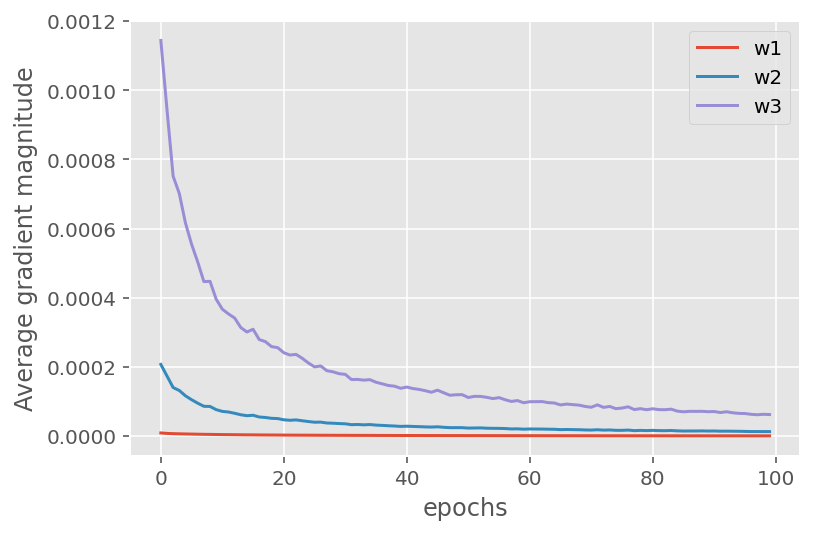

CPU times: user 8h 10min 37s, sys: 11min 19s, total: 8h 21min 57s
Wall time: 2h 7min 23s


In [26]:
%%time
nn_3l = ThreeLayerPerceptron(**params)
nn_3l.fit(X_train, y_train, print_progress=1)
yhat_nn3l = nn_3l.predict(X_test)
print()
print('Accuracy:',accuracy_score(y_test,yhat_nn3l))
print(np.unique(yhat_nn3l))
nn_3l.graph_gradient()

### 3.2 Four layers neural network

In [27]:
class FourLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, W3, W4):
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._sigmoid(Z4)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5

    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, A5 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4)
        y_pred = np.argmax(A5, axis=0)
        return y_pred
    
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden + 1))
        W2[:,:1] = 0

        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden + 1))
        W3[:,:1] = 0

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W4[:,:1] = 0
        
        return W1, W2, W3, W4

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:,1:]**2) + np.mean(W4[:,1:]**2))

    def _cost(self,A5,Y_enc,W1,W2,W3,W4):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A5)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term

    def graph_gradient(self):
        ax = plt.subplot(1,1,1)
        plt.plot(abs(self.grad_w1_), label='w1')
        plt.plot(abs(self.grad_w2_), label='w2')
        plt.plot(abs(self.grad_w3_), label='w3')
        plt.plot(abs(self.grad_w4_), label='w4')
        plt.legend()
        plt.ylabel('Average gradient magnitude')
        plt.xlabel('epochs')
        plt.show()

    def _get_gradient(self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V4 = -2*(Y_enc-A5)*A5*(1-A5)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3[1:,:])
        V1 = A2*(1-A2)*(W2.T @ V2[1:,:])
        
        grad4 = V4 @ A4.T
        grad3 = V3[1:,:] @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C

        return grad1, grad2, grad3, grad4
    

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4 = self._initialize_weights()
        
        # init average magnitude of the gradient for each layer, for each epoch
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum
        rho_W3_prev = np.zeros(self.W3.shape) # for momentum
        rho_W4_prev = np.zeros(self.W4.shape) # for momentum

        self.cost_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            eta = self.eta / (1 + self.decrease_const*i) # decreasing learning rate
            # there are many forms of adaptive learning rates out there!

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches== self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            mini_grad1 = []
            mini_grad2 = []
            mini_grad3 = []
            mini_grad4 = []

            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.W4)
                
                cost = self._cost(A5,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4)

                rho_W1, rho_W2, rho_W3, rho_W4 = eta * grad1, eta * grad2, eta * grad3, eta * grad4
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev)) # update with momentum
                self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev)) # update with momentum

                mini_grad1.append(np.mean(np.abs(rho_W1 + (self.alpha * rho_W1_prev))))
                mini_grad2.append(np.mean(np.abs(rho_W2 + (self.alpha * rho_W2_prev))))
                mini_grad3.append(np.mean(np.abs(rho_W3 + (self.alpha * rho_W3_prev))))
                mini_grad4.append(np.mean(np.abs(rho_W4 + (self.alpha * rho_W4_prev))))

                rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev = rho_W1, rho_W2, rho_W3, rho_W4

            #update mean gradient for each epoch
            self.grad_w1_[i] = np.mean(mini_grad1)
            self.grad_w2_[i] = np.mean(mini_grad2)
            self.grad_w3_[i] = np.mean(mini_grad3)
            self.grad_w4_[i] = np.mean(mini_grad4)

            self.cost_.append(mini_cost)
        
        return self


Epoch: 100/100
Accuracy: 0.7411303630363036
[0 1 2 3]


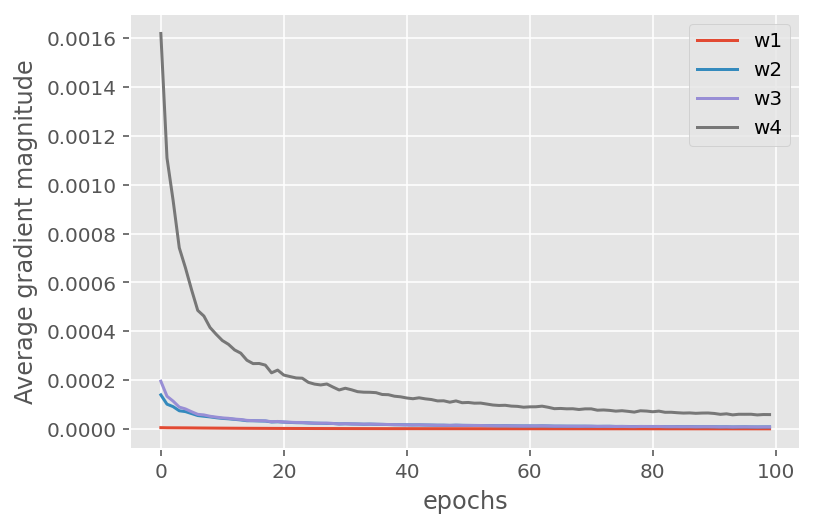

CPU times: user 3h 17min 47s, sys: 22min 12s, total: 3h 39min 59s
Wall time: 47min 46s


In [28]:
%%time
params['n_hidden'] = 200
nn_4l = FourLayerPerceptron(**params)
nn_4l.fit(X_train, y_train, print_progress=1)
yhat_nn4l = nn_4l.predict(X_test)
print()
print('Accuracy:',accuracy_score(y_test,yhat_nn4l))
print(np.unique(yhat_nn4l))
nn_4l.graph_gradient()

### 3.3 Five layers neural network

In [29]:
class FiveLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, W3, W4, W5):
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._sigmoid(Z4)
        A5 = self._add_bias_unit(A5, how='row')
        Z5 = W5 @ A5
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6

    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred
    
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden + 1))
        W2[:,:1] = 0

        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden + 1))
        W3[:,:1] = 0

        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden + 1))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden + 1))
        W4[:,:1] = 0

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W5[:,:1] = 0
        
        return W1, W2, W3, W4, W5

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:,1:]**2) + np.mean(W4[:,1:]**2) + np.mean(W5[:,1:]**2))

    def _cost(self,A6,Y_enc,W1,W2,W3,W4,W5):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A6)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term

    def graph_gradient(self):
        ax = plt.subplot(1,1,1)
        plt.plot(abs(self.grad_w1_), label='w1')
        plt.plot(abs(self.grad_w2_), label='w2')
        plt.plot(abs(self.grad_w3_), label='w3')
        plt.plot(abs(self.grad_w4_), label='w4')
        plt.plot(abs(self.grad_w5_), label='w5')
        plt.legend()
        plt.ylabel('Average gradient magnitude')
        plt.xlabel('epochs')
        plt.show()

    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V5 = -2*(Y_enc-A6)*A6*(1-A6)
        V4 = A5*(1-A5)*(W5.T @ V5)
        V3 = A4*(1-A4)*(W4.T @ V4[1:,:])
        V2 = A3*(1-A3)*(W3.T @ V3[1:,:])
        V1 = A2*(1-A2)*(W2.T @ V2[1:,:])
        
        grad5 = V5 @ A5.T
        grad4 = V4[1:,:] @ A4.T
        grad3 = V3[1:,:] @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C
        grad5[:, 1:] += W5[:, 1:] * self.l2_C

        return grad1, grad2, grad3, grad4, grad5
    

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5 = self._initialize_weights()
        
        # init average magnitude of the gradient for each layer, for each epoch
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        self.grad_w5_ = np.zeros(self.epochs)

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum
        rho_W3_prev = np.zeros(self.W3.shape) # for momentum
        rho_W4_prev = np.zeros(self.W4.shape) # for momentum
        rho_W5_prev = np.zeros(self.W5.shape) # for momentum

        self.cost_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            eta = self.eta / (1 + self.decrease_const*i) # decreasing learning rate
            # there are many forms of adaptive learning rates out there!

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches== self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            mini_grad1 = []
            mini_grad2 = []
            mini_grad3 = []
            mini_grad4 = []
            mini_grad5 = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.W4,
                                                       self.W5)
                
                cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4, grad5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4, W5=self.W5)

                rho_W1, rho_W2, rho_W3, rho_W4, rho_W5 = eta * grad1, eta * grad2, eta * grad3, eta * grad4, eta * grad5
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev)) # update with momentum
                self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev)) # update with momentum
                self.W5 -= (rho_W5 + (self.alpha * rho_W5_prev)) # update with momentum

                mini_grad1.append(np.mean(np.abs(rho_W1 + (self.alpha * rho_W1_prev))))
                mini_grad2.append(np.mean(np.abs(rho_W2 + (self.alpha * rho_W2_prev))))
                mini_grad3.append(np.mean(np.abs(rho_W3 + (self.alpha * rho_W3_prev))))
                mini_grad4.append(np.mean(np.abs(rho_W4 + (self.alpha * rho_W4_prev))))
                mini_grad5.append(np.mean(np.abs(rho_W5 + (self.alpha * rho_W5_prev))))

                rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev, rho_W5_prev = rho_W1, rho_W2, rho_W3, rho_W4, rho_W5

            #update mean gradient for each epoch
            self.grad_w1_[i] = np.mean(mini_grad1)
            self.grad_w2_[i] = np.mean(mini_grad2)
            self.grad_w3_[i] = np.mean(mini_grad3)
            self.grad_w4_[i] = np.mean(mini_grad4)
            self.grad_w5_[i] = np.mean(mini_grad5)

            self.cost_.append(mini_cost)
        
        return self

Epoch: 100/100
Accuracy: 0.7409928492849285
[0 1 2 3]


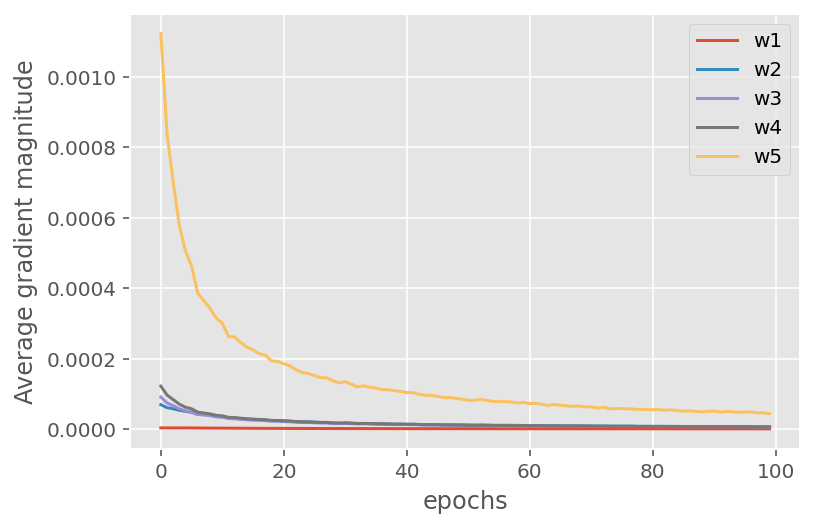

CPU times: user 59min 17s, sys: 24min 35s, total: 1h 23min 52s
Wall time: 11min 5s


In [30]:
%%time
params['n_hidden'] = 200
params['alpha'] = 0
nn_5l = FiveLayerPerceptron(**params)
nn_5l.fit(X_train, y_train, print_progress=1)
yhat_nn5l = nn_5l.predict(X_test)
print()
print('Accuracy:',accuracy_score(y_test,yhat_nn5l))
print(np.unique(yhat_nn5l))
nn_5l.graph_gradient()

Epoch: 100/100
Accuracy: 0.7409928492849285
[0 1 2 3]


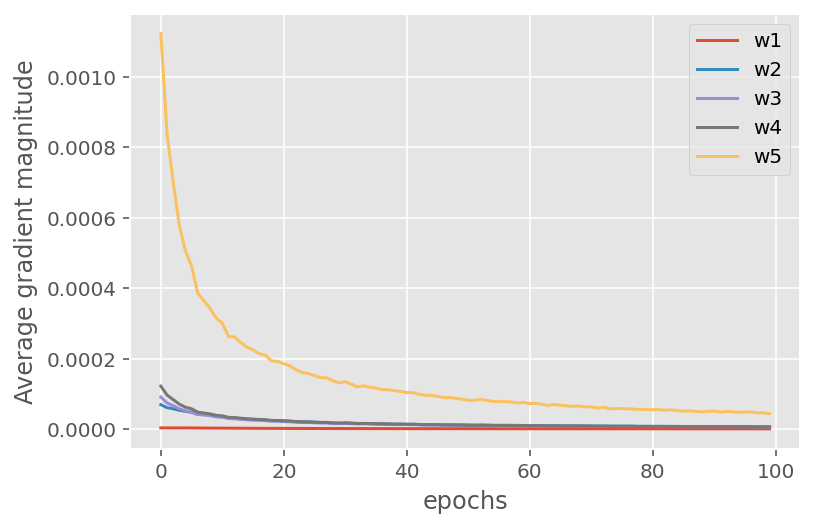

CPU times: user 1h 4s, sys: 25min 8s, total: 1h 25min 12s
Wall time: 11min 14s


In [31]:
%%time
params['n_hidden'] = 200
nn_5l_mo = FiveLayerPerceptron(**params)
nn_5l_mo.fit(X_train, y_train, print_progress=1)
yhat_nn5l_mo = nn_5l_mo.predict(X_test)
print()
print('Accuracy:',accuracy_score(y_test,yhat_nn5l_mo))
print(np.unique(yhat_nn5l_mo))
nn_5l_mo.graph_gradient()

### five layer neural network with adaptive mometum(AdaGrad)

In [32]:
class FiveLayerPerceptronAdaGrad(FiveLayerPerceptron):
    def __init__(self,epsilon=1e-08,**kwds):
        self.epsilon = epsilon
        super().__init__(**kwds)

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5 = self._initialize_weights()
        
        # init average magnitude of the gradient for each layer, for each epoch
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        self.grad_w5_ = np.zeros(self.epochs)

        # init adaptive momentum variables m and v
        g_W1 = np.zeros((self.epochs,self.W1.shape[0],self.W1.shape[1]))
        g_W2 = np.zeros((self.epochs,self.W2.shape[0],self.W2.shape[1]))
        g_W3 = np.zeros((self.epochs,self.W3.shape[0],self.W3.shape[1]))
        g_W4 = np.zeros((self.epochs,self.W4.shape[0],self.W4.shape[1]))
        g_W5 = np.zeros((self.epochs,self.W5.shape[0],self.W5.shape[1]))
     

        self.cost_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            eta = self.eta / (1 + self.decrease_const*i) # decreasing learning rate
            # there are many forms of adaptive learning rates out there!

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches== self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            mini_grad1 = []
            mini_grad2 = []
            mini_grad3 = []
            mini_grad4 = []
            mini_grad5 = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.W4,
                                                       self.W5)
                
                cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4, grad5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4, W5=self.W5)

                if i>0:
                    g_W1[i] = g_W1[i-1] + grad1*grad1
                    g_W2[i] = g_W2[i-1] + grad2*grad2
                    g_W3[i] = g_W3[i-1] + grad3*grad3
                    g_W4[i] = g_W4[i-1] + grad4*grad4
                    g_W5[i] = g_W5[i-1] + grad5*grad5
                else :
                    g_W1[i] = grad1*grad1
                    g_W2[i] = grad2*grad2
                    g_W3[i] = grad3*grad3
                    g_W4[i] = grad4*grad4
                    g_W5[i] = grad5*grad5

                self.W1 -= eta * grad1/np.sqrt(g_W1[i]+self.epsilon) # update with momentum
                self.W2 -= eta * grad2/np.sqrt(g_W2[i]+self.epsilon) # update with momentum
                self.W3 -= eta * grad3/np.sqrt(g_W3[i]+self.epsilon) # update with momentum
                self.W4 -= eta * grad4/np.sqrt(g_W4[i]+self.epsilon) # update with momentum
                self.W5 -= eta * grad5/np.sqrt(g_W5[i]+self.epsilon) # update with momentum

                mini_grad1.append(np.mean(np.abs(eta * grad1/np.sqrt(g_W1[i]+self.epsilon))))
                mini_grad2.append(np.mean(np.abs(eta * grad2/np.sqrt(g_W2[i]+self.epsilon))))
                mini_grad3.append(np.mean(np.abs(eta * grad3/np.sqrt(g_W3[i]+self.epsilon))))
                mini_grad4.append(np.mean(np.abs(eta * grad4/np.sqrt(g_W4[i]+self.epsilon))))
                mini_grad5.append(np.mean(np.abs(eta * grad5/np.sqrt(g_W5[i]+self.epsilon))))

            #update mean gradient for each epoch
            self.grad_w1_[i] = np.mean(mini_grad1)
            self.grad_w2_[i] = np.mean(mini_grad2)
            self.grad_w3_[i] = np.mean(mini_grad3)
            self.grad_w4_[i] = np.mean(mini_grad4)
            self.grad_w5_[i] = np.mean(mini_grad5)

            self.cost_.append(mini_cost)
        
        return self


Epoch: 100/100
Accuracy: 0.7410616061606161
[0 1 2 3]


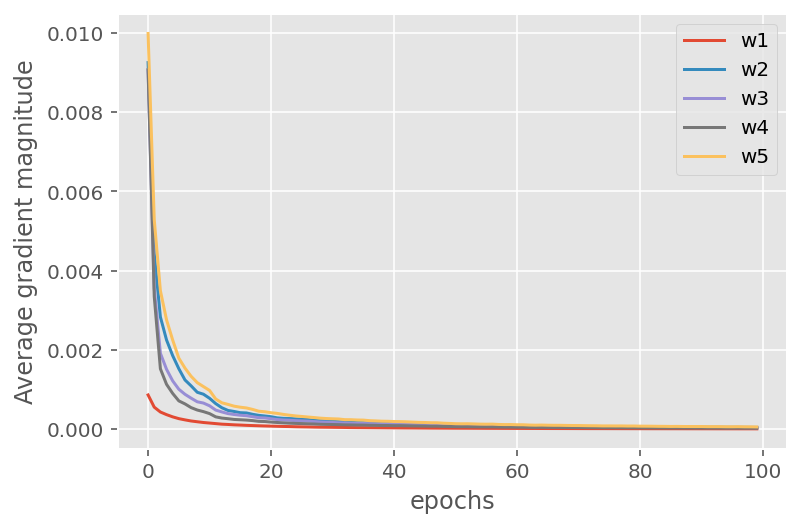

CPU times: user 1h 43min 41s, sys: 52min 38s, total: 2h 36min 20s
Wall time: 20min 41s


In [33]:
%%time
params = dict(n_hidden=200, 
              l2_C=1e-2, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=1e-2,  # learning rate
              random_state=1,
              onehot=True,
              alpha=0.9,
              decrease_const=0.1,
              minibatches=len(X_train)/64,
              shuffle=True,
              epsilon = 1e-08
              )

nn_5l_adagrad = FiveLayerPerceptronAdaGrad(**params)
nn_5l_adagrad.fit(X_train, y_train, print_progress=1)
yhat_nn5ladagrad = nn_5l_adagrad.predict(X_test)
print()
print('Accuracy:',accuracy_score(y_test,yhat_nn5ladagrad))
print(np.unique(yhat_nn5ladagrad))
nn_5l_adagrad.graph_gradient()

### 3.4 Compare the performance of this model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique. 

In [34]:
%%time
accuracy_nn5ladagrad = accuracy_score(y_test,yhat_nn5ladagrad)
accuracy_nn5l = accuracy_score(y_test,yhat_nn5l)

d = np.abs(accuracy_nn5ladagrad-accuracy_nn5l)
v = accuracy_nn5ladagrad*(1-accuracy_nn5ladagrad)/X_test.shape[0] + accuracy_nn5l*(1-accuracy_nn5l)/X_test.shape[0]

print('The difference of model 5 layer network with momentum and 5 layer network with AdaGrad is %f,%f ' % (d-1.96*np.sqrt(v),d+1.96*np.sqrt(v)))

The difference of model 5 layer network with momentum and 5 layer network with AdaGrad is -0.010000,0.010137 
CPU times: user 2.74 ms, sys: 2.62 ms, total: 5.35 ms
Wall time: 1.16 ms


### With 95% confidence, the two models are not different because the difference between them contains zero.

## 4.Exceptional Work

One idea (required for 7000 level students):  Implement adaptive momentum (AdaM) in the five layer neural network and quantify the performance

In [35]:
class FiveLayerPerceptronAdam(FiveLayerPerceptron):
    def __init__(self,beta1=0.9,beta2=0.999,epsilon=1e-08,**kwds):
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        super().__init__(**kwds)

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5 = self._initialize_weights()
        
        # init average magnitude of the gradient for each layer, for each epoch
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)
        self.grad_w4_ = np.zeros(self.epochs)
        self.grad_w5_ = np.zeros(self.epochs)

        # init adaptive momentum variables m and v
        m_W1 = np.zeros((self.epochs,self.W1.shape[0],self.W1.shape[1]))
        m_W2 = np.zeros((self.epochs,self.W2.shape[0],self.W2.shape[1]))
        m_W3 = np.zeros((self.epochs,self.W3.shape[0],self.W3.shape[1]))
        m_W4 = np.zeros((self.epochs,self.W4.shape[0],self.W4.shape[1]))
        m_W5 = np.zeros((self.epochs,self.W5.shape[0],self.W5.shape[1]))
        v_W1 = np.zeros((self.epochs,self.W1.shape[0],self.W1.shape[1]))
        v_W2 = np.zeros((self.epochs,self.W2.shape[0],self.W2.shape[1]))
        v_W3 = np.zeros((self.epochs,self.W3.shape[0],self.W3.shape[1]))
        v_W4 = np.zeros((self.epochs,self.W4.shape[0],self.W4.shape[1]))
        v_W5 = np.zeros((self.epochs,self.W5.shape[0],self.W5.shape[1]))

        self.cost_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            eta = self.eta / (1 + self.decrease_const*i) # decreasing learning rate
            # there are many forms of adaptive learning rates out there!

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches== self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            mini_grad1 = []
            mini_grad2 = []
            mini_grad3 = []
            mini_grad4 = []
            mini_grad5 = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.W4,
                                                       self.W5)
                
                cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4, grad5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4, W5=self.W5)

                
                m_W1[i] = self.beta1*m_W1[i] + (1-self.beta1) * grad1
                m_W2[i] = self.beta1*m_W2[i] + (1-self.beta1) * grad2
                m_W3[i] = self.beta1*m_W3[i] + (1-self.beta1) * grad3
                m_W4[i] = self.beta1*m_W4[i] + (1-self.beta1) * grad4
                m_W5[i] = self.beta1*m_W5[i] + (1-self.beta1) * grad5
                
                v_W1[i] = self.beta2*v_W1[i] + (1-self.beta2) * (grad1**2)
                v_W2[i] = self.beta2*v_W2[i] + (1-self.beta2) * (grad2**2)
                v_W3[i] = self.beta2*v_W3[i] + (1-self.beta2) * (grad3**2)
                v_W4[i] = self.beta2*v_W4[i] + (1-self.beta2) * (grad4**2)
                v_W5[i] = self.beta2*v_W5[i] + (1-self.beta2) * (grad5**2)

                mhat_W1 = m_W1[i]/(1.0-self.beta1**(i+1))
                mhat_W2 = m_W2[i]/(1.0-self.beta1**(i+1))
                mhat_W3 = m_W3[i]/(1.0-self.beta1**(i+1))
                mhat_W4 = m_W4[i]/(1.0-self.beta1**(i+1))
                mhat_W5 = m_W5[i]/(1.0-self.beta1**(i+1))

                vhat_W1 = v_W1[i]/(1.0-self.beta2**(i+1)) 
                vhat_W2 = v_W2[i]/(1.0-self.beta2**(i+1)) 
                vhat_W3 = v_W3[i]/(1.0-self.beta2**(i+1)) 
                vhat_W4 = v_W4[i]/(1.0-self.beta2**(i+1)) 
                vhat_W5 = v_W5[i]/(1.0-self.beta2**(i+1)) 

                self.W1 -= eta * mhat_W1/np.sqrt(vhat_W1+self.epsilon) # update with momentum
                self.W2 -= eta * mhat_W2/np.sqrt(vhat_W2+self.epsilon) # update with momentum
                self.W3 -= eta * mhat_W3/np.sqrt(vhat_W3+self.epsilon) # update with momentum
                self.W4 -= eta * mhat_W4/np.sqrt(vhat_W4+self.epsilon) # update with momentum
                self.W5 -= eta * mhat_W5/np.sqrt(vhat_W5+self.epsilon) # update with momentum

                mini_grad1.append(np.mean(np.abs(eta * mhat_W1/np.sqrt(vhat_W1+self.epsilon))))
                mini_grad2.append(np.mean(np.abs(eta * mhat_W2/np.sqrt(vhat_W2+self.epsilon))))
                mini_grad3.append(np.mean(np.abs(eta * mhat_W3/np.sqrt(vhat_W3+self.epsilon))))
                mini_grad4.append(np.mean(np.abs(eta * mhat_W4/np.sqrt(vhat_W4+self.epsilon))))
                mini_grad5.append(np.mean(np.abs(eta * mhat_W5/np.sqrt(vhat_W5+self.epsilon))))

            #update mean gradient for each epoch
            self.grad_w1_[i] = np.mean(mini_grad1)
            self.grad_w2_[i] = np.mean(mini_grad2)
            self.grad_w3_[i] = np.mean(mini_grad3)
            self.grad_w4_[i] = np.mean(mini_grad4)
            self.grad_w5_[i] = np.mean(mini_grad5)

            self.cost_.append(mini_cost)
        
        return self


Epoch: 60/60
Accuracy: 0.7419554455445545
[0 1 2 3]


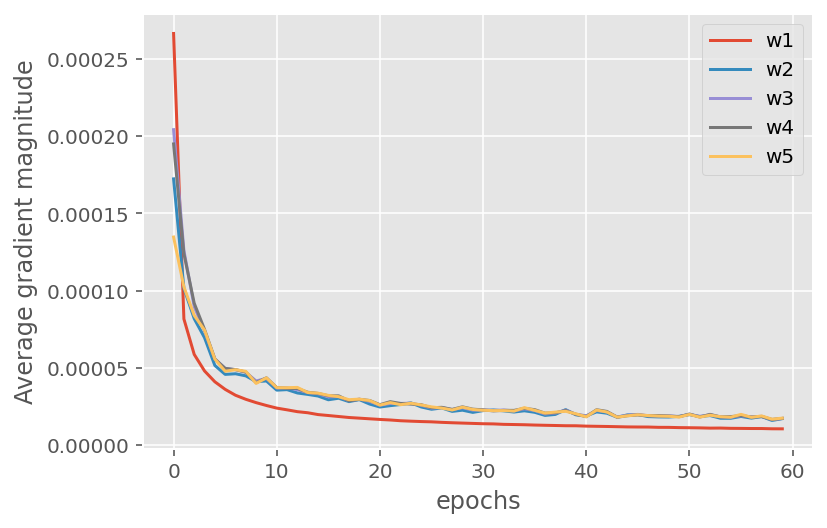

CPU times: user 20min 8s, sys: 10min 1s, total: 30min 9s
Wall time: 3min 57s


In [36]:
%%time
params = dict(n_hidden=100, 
              l2_C=1e-2, # tradeoff L2 regularizer
              epochs=60, # iterations
              eta=1e-3,  # learning rate
              random_state=1,
              onehot=True,
              alpha=0.9,
              decrease_const=0.1,
              minibatches=len(X_train)/128,
              shuffle=True,
              beta1 = 0.9,
              beta2 = 0.999,
              epsilon = 1e-08
              )

nn_5l_adm = FiveLayerPerceptronAdam(**params)
nn_5l_adm.fit(X_train, y_train, print_progress=1)
yhat_nn5ladm = nn_5l_adm.predict(X_test)
print()
print('Accuracy:',accuracy_score(y_test,yhat_nn5ladm))
print(np.unique(yhat_nn5ladm))
nn_5l_adm.graph_gradient()

### Four layers of Relu and final layer using sigmoid

In [37]:
class FiveLayerPerceptronAdamRelu(FiveLayerPerceptronAdam):
    @staticmethod
    def _relu(Z):
        return np.maximum(0, Z.copy())

    def _feedforward(self, X, W1, W2, W3, W4, W5):
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._relu(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._relu(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._relu(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._relu(Z4)
        A5 = self._add_bias_unit(A5, how='row')
        Z5 = W5 @ A5
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden + 1))
        W2[:,:1] = 0

        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + self.n_hidden + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden + 1))
        W3[:,:1] = 0

        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + self.n_hidden + 1))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden + 1))
        W4[:,:1] = 0

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W5[:,:1] = 0
        
        return W1, W2, W3, W4, W5

    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V5 = -2*(Y_enc-A6)*A6*(1-A6)

        V4 = W5.T @ V5
        Z4_with_bias = self._add_bias_unit(Z4,how='row')
        V4[Z4_with_bias<=0] = 0

        V3 = W4.T @ V4[1:,:]
        Z3_with_bias = self._add_bias_unit(Z3,how='row')
        V3[Z3_with_bias<=0] = 0

        # V2 = A3*(1-A3)*(W3.T @ V3[1:,:])
        V2 = W3.T @ V3[1:,:]
        Z2_with_bias = self._add_bias_unit(Z2,how='row')
        V2[Z2_with_bias<=0] = 0

        # V1 = A2*(1-A2)*(W2.T @ V2[1:,:])
        V1 = W2.T @ V2[1:,:]
        Z1_with_bias = self._add_bias_unit(Z1,how='row')
        V1[Z1_with_bias<=0] = 0
        
        grad5 = V5 @ A5.T
        grad4 = V4[1:,:] @ A4.T
        grad3 = V3[1:,:] @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C
        grad5[:, 1:] += W5[:, 1:] * self.l2_C

        return grad1, grad2, grad3, grad4, grad5
    

Epoch: 60/60
Accuracy: 0.7071644664466447
[0 1 2 3]


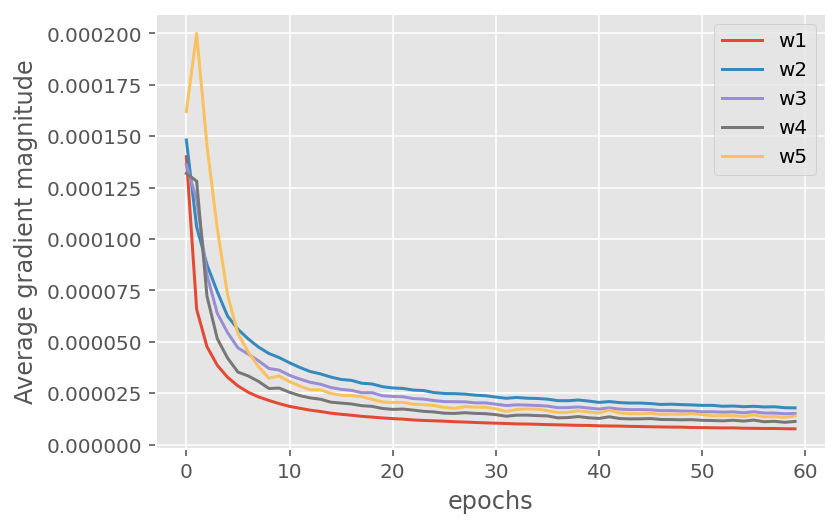

CPU times: user 19min 48s, sys: 9min 27s, total: 29min 15s
Wall time: 3min 50s


In [38]:
%%time
params = dict(n_hidden=100, 
              l2_C=1e-2, # tradeoff L2 regularizer
              epochs=60, # iterations
              eta=1e-3,  # learning rate
              random_state=1,
              onehot=True,
              alpha=0.9,
              decrease_const=0.1,
              minibatches=len(X_train)/128,
              shuffle=True,
              beta1 = 0.9,
              beta2 = 0.999,
              epsilon = 1e-08
              )

nn_5l_admrelu = FiveLayerPerceptronAdamRelu(**params)
nn_5l_admrelu.fit(X_train, y_train, print_progress=1)
yhat_nn5ladmrelu = nn_5l_admrelu.predict(X_test)
print()
print('Accuracy:',accuracy_score(y_test,yhat_nn5ladmrelu))
print(np.unique(yhat_nn5ladmrelu))
nn_5l_admrelu.graph_gradient()

### I'm curious if I use MLPClassifier to get the accuracy.

In [39]:
%%time

clf = MLPClassifier(hidden_layer_sizes=(50,50,50,50,50), 
                    activation='relu', # type of non-linearity, every layer except output layer
                    solver='adam', 
                    alpha=1e-2, # L2 penalty
                    batch_size= 256, # min of 200, num_samples
                    learning_rate='adaptive', # adapt learning? 
                    learning_rate_init=0.01, # only SGD
                    power_t=1,    # only SGD with inverse scaling of learning rate
                    max_iter=300, # stopping criteria
                    shuffle=True, 
                    random_state=1, 
                    tol=0, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=False, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.0, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.99, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('Validation Acc:',accuracy_score(y_test,yhat))

Validation Acc: 0.7203657865786579
CPU times: user 17min 29s, sys: 6min 27s, total: 23min 56s
Wall time: 3min 4s


#### It's time costly for doing grid search.

In [40]:
# %%time
# param_grid = [{'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
#                'hidden_layer_sizes':[50,100,125,150,200,250,300],
#                'momentum':[0.1,0.3,0.5,0.7,0.9],
#                }]

# gs = GridSearchCV(estimator=clf,
#                   param_grid=param_grid, 
#                   scoring='accuracy', 
#                   cv=10,
#                   )
# gs = gs.fit(X_train, y_train)
# print(gs.best_score_)
# print(gs.best_params_)